In [45]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

In [46]:
# Load dataset
data = pd.read_csv("../data/01_clean_data.csv")

In [47]:
# Quick check that evrything looks OK 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PERSON_ID           16048 non-null  int64  
 1   WEIGHT              16048 non-null  float64
 2   GENDER              16048 non-null  object 
 3   NUMBER_OF_CHILDREN  16048 non-null  int64  
 4   AGE                 16048 non-null  int64  
 5   HOUSEHOLD_SIZE      16048 non-null  int64  
 6   TV_TOTAL            16048 non-null  float64
 7   FLYERS              16048 non-null  float64
 8   PRINT_TOTAL         16048 non-null  float64
 9   ONLINE_VIDEO        16048 non-null  float64
 10  ONLINE_DISPLAY      16048 non-null  float64
 11  ONLINE_TOTAL        16048 non-null  float64
 12  TIKTOK              16048 non-null  float64
 13  YOUTUBE_TOTAL       16048 non-null  float64
 14  YOUTUBE_MOBILE      16048 non-null  float64
 15  YOUTUBE_DESKTOP     16048 non-null  float64
 16  YOUT

In [48]:
# Get basic stats on numerical columns
data.describe()

,PERSON_ID,WEIGHT,NUMBER_OF_CHILDREN,AGE,HOUSEHOLD_SIZE,TV_TOTAL,FLYERS,PRINT_TOTAL,ONLINE_VIDEO,ONLINE_DISPLAY,ONLINE_TOTAL,TIKTOK,YOUTUBE_TOTAL,YOUTUBE_MOBILE,YOUTUBE_DESKTOP,YOUTUBE_TABLET,YOUTUBE_CTV,PINTEREST
count,1.604800e+04,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000,16048.000000
mean,9.249875e+07,5125.119982,0.084746,58.730808,2.121635,5.731493,0.424850,0.689369,0.191426,0.087114,0.278539,0.047420,0.560257,0.306705,0.068420,0.059571,0.125561,0.672856
std,2.174318e+08,4758.618092,0.332748,15.417848,1.090489,9.966786,0.971372,1.687651,1.012046,0.685571,1.369052,0.466682,1.287871,0.991847,0.378989,0.391619,0.577620,3.365729
min,1.000000e+00,718.050000,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.993625e+04,2718.800000,0.000000,47.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.207340e+05,3961.460000,0.000000,60.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.529975e+07,5719.180000,0.000000,70.000000,3.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.988330e+08,76258.290000,3.000000,101.000000,10.000000,113.000000,3.000000,23.000000,18.000000,13.000000,24.000000,9.000000,14.000000,14.000000,8.000000,12.000000,12.000000,63.000000


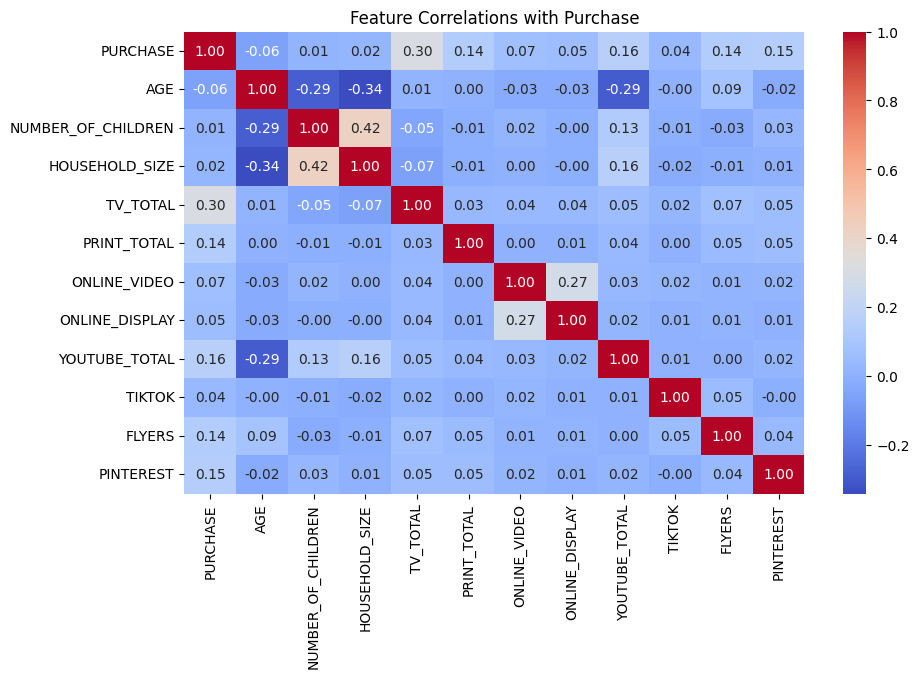

In [49]:
corr = data[['PURCHASE', 'AGE', 'NUMBER_OF_CHILDREN', 'HOUSEHOLD_SIZE', 'TV_TOTAL', 'PRINT_TOTAL', 'ONLINE_VIDEO', 'ONLINE_DISPLAY', 'YOUTUBE_TOTAL', 'TIKTOK', 'FLYERS', 'PINTEREST']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlations with Purchase")
plt.show()

- Highest correlation to purchase is TV Total which is nearly double what we have for the other types of media which indicates it is more effective driver
- Age has a correlation to household size and number of children as it makes sence. People with children would typically be of a certain age range and these children are likely to be living with them. Youtube Totals correlation is higher than TV totals in these observations which may indicate that Youtube is a medium that is reaching younger people more effectively than the rest.
- `ONLINE_DISPLAY` and `ONLINE_VIDEO`have a correlation of 27% which indicates taht there might be a certain level of overlap between the two

## 1. Outlier Detection

Several media exposure features contain observations that deviate significantly from the mean, indicating the possible presence of outliers. Detecting and addressing these outliers could be crucial, as they can skew analysis and model performance, thus resulting in misleading insights.

I like using **Isolation Forrest** as it can handle most types of datasets and provides an outlier score which can be used as an additional model training feature.

In [50]:
# Apply one-hot encoding
data_od = data.drop(columns=(['PURCHASE', 'WEIGHT']))

data_od = pd.get_dummies(data_od, columns=['GENDER'], drop_first=True)

In [51]:
# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.07, random_state=42)  # Set contamination to the expected outlier proportion
outliers = iso_forest.fit_predict(data_od)

# Check number of outliers
print((outliers == -1).sum())

1124


[]

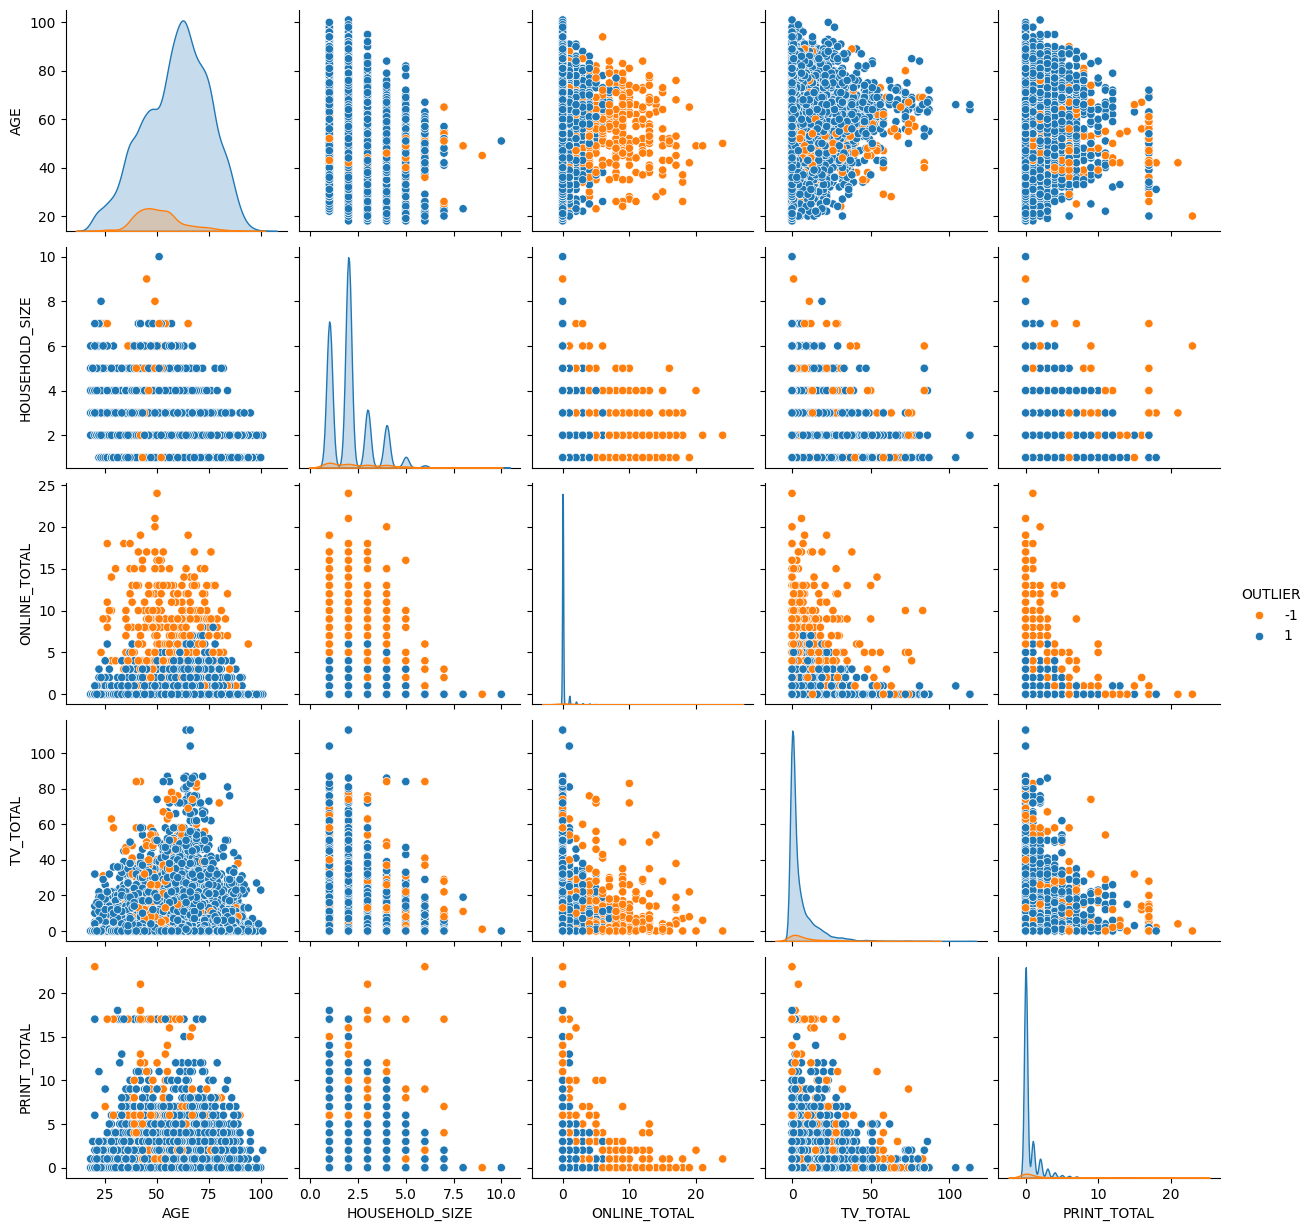

In [52]:
# Visualize Outliers
data['OUTLIER'] = outliers
data_to_plot = data[["AGE", "HOUSEHOLD_SIZE", "ONLINE_TOTAL", "TV_TOTAL", "PRINT_TOTAL", "OUTLIER"]]

palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(data_to_plot, vars=data_to_plot.drop(columns=["OUTLIER"]), hue='OUTLIER', palette=palette)
plt.plot()

#### Results
At this stage, I see two possible approaches for handling the detected outliers:

1. Dropping the outlier observations – While this is a common approach, I’m hesitant to remove them outright. The anomalies don’t appear to be excessively extreme, and eliminating them could result in a loss of valuable information rather than improving the dataset.

2. Attaching outlier scores to the dataset – Instead of discarding data, I will retain all observations and store the outlier scores. This allows me to incorporate them as an additional feature during model training, giving the models deeper insight into potential anomalies in the data.

I’ve decided to go with the second approach, as it provides flexibility while preserving as much information as possible.

In [53]:
# Attach results to df
data["OUTLIER_SCORE"] = iso_forest.decision_function(data_od)

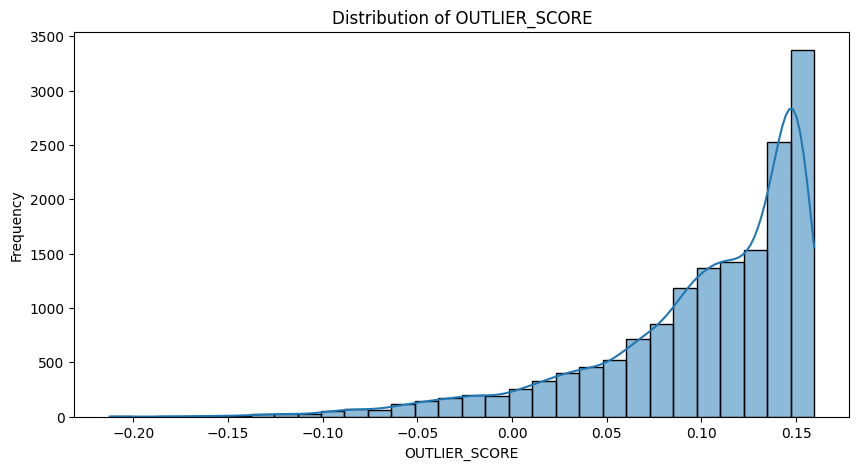

In [54]:
# Plot the distribution of OUTLIER_SCORE (continuous)
plt.figure(figsize=(10, 5))
sns.histplot(data['OUTLIER_SCORE'], kde=True, bins=30)
plt.title("Distribution of OUTLIER_SCORE")
plt.xlabel("OUTLIER_SCORE")
plt.ylabel("Frequency")
plt.show()

An overview of the `OUTLIER_SCORE` showing the distribution of the feature. It's important to note that outlier observations are marked with a negative score.

Same goes for the `OUTLIER` flag where -1 signifies  what the model deems to be outliers.

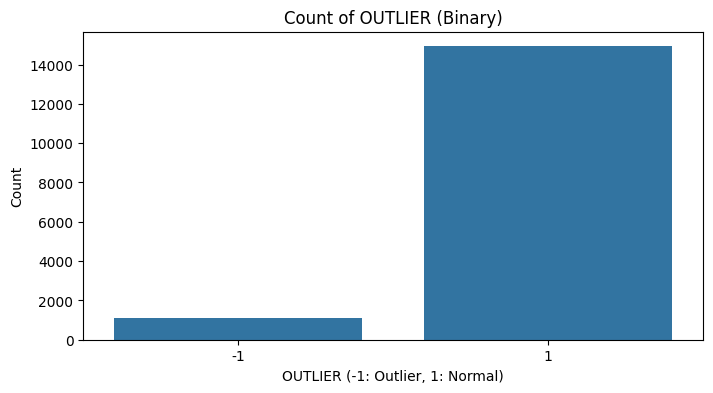

In [55]:
# Plot the distribution of OUTLIER (binary)
plt.figure(figsize=(8, 4))
sns.countplot(x='OUTLIER', data=data)
plt.title("Count of OUTLIER (Binary)")
plt.xlabel("OUTLIER (-1: Outlier, 1: Normal)")
plt.ylabel("Count")
plt.show()

In [56]:
# Remove outliers
# data = data[data['OUTLIER'] == 1]

In [57]:
# Drop outlier features
data.drop(columns=[
    'OUTLIER', 
    # 'OUTLIER_SCORE'
    ], inplace=True)

In [58]:
# Final check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PERSON_ID           16048 non-null  int64  
 1   WEIGHT              16048 non-null  float64
 2   GENDER              16048 non-null  object 
 3   NUMBER_OF_CHILDREN  16048 non-null  int64  
 4   AGE                 16048 non-null  int64  
 5   HOUSEHOLD_SIZE      16048 non-null  int64  
 6   TV_TOTAL            16048 non-null  float64
 7   FLYERS              16048 non-null  float64
 8   PRINT_TOTAL         16048 non-null  float64
 9   ONLINE_VIDEO        16048 non-null  float64
 10  ONLINE_DISPLAY      16048 non-null  float64
 11  ONLINE_TOTAL        16048 non-null  float64
 12  TIKTOK              16048 non-null  float64
 13  YOUTUBE_TOTAL       16048 non-null  float64
 14  YOUTUBE_MOBILE      16048 non-null  float64
 15  YOUTUBE_DESKTOP     16048 non-null  float64
 16  YOUT

## 2. Feature Engineering
I will create additional features to enhance data analysis and improve model performance. These engineered features will hopefully help uncover patterns, relationships, and trends that may not be immediately visible in the raw data.

### 2.1 Media-Specific Aggregations

#### Total Media Exposure
This feature aggregates all media interactions per individual, providing a holistic view of media engagement. It's aim is to help identify trends in media consumption across different demographic groups.

In [59]:
media_channels = ['TV_TOTAL', 'PRINT_TOTAL', 'ONLINE_VIDEO', 'ONLINE_DISPLAY', 'YOUTUBE_TOTAL', 'TIKTOK', 'FLYERS', 'PINTEREST']
data['TOTAL_MEDIA_EXPOSURE'] = data[media_channels].sum(axis=1)

Before proceeding, let's examine the correlations between media channels to ensure there is no significant overlap. If two channels are highly correlated, it could indicate that one is already capturing the exposure from another, leading to potential double counting.

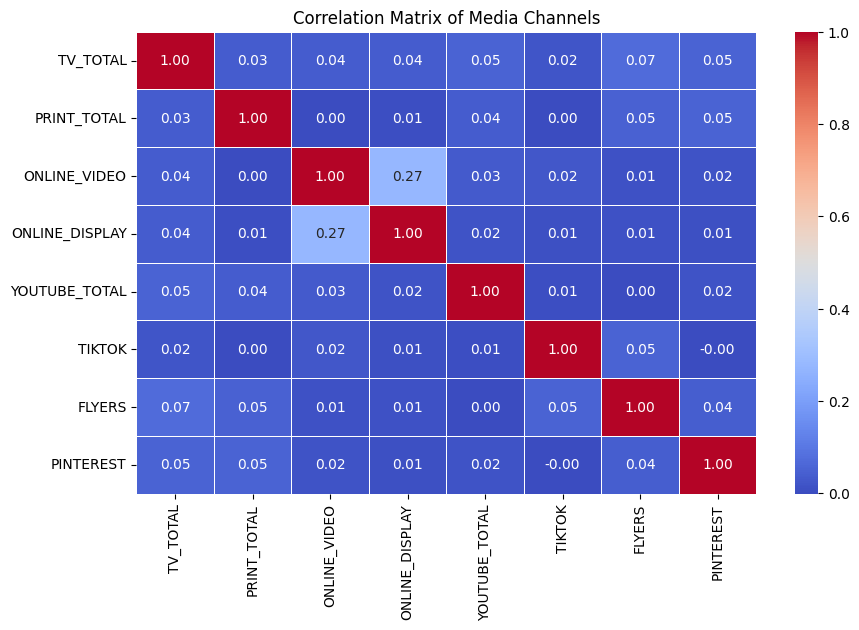

In [60]:
# Compute correlation matrix
corr_matrix = data[media_channels].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Media Channels")
plt.show()

There does seem to be a not completely insignificant correlation between **ONLINE_DISPLAY** and **ONLINE_VIDEO**, suggesting that there is some overlap between the two.

#### Totals per media type
These next four break down total media exposure into specific categories, helping to distinguish between digital, traditional, social, and video-based media consumption.. It should enable a comparative analysis of how different demographic groups consume various media types, indicating preferences and trends.

In [61]:
# Digital media includes all online platforms
data["DIGITAL_MEDIA_TOTAL"] = data["ONLINE_TOTAL"] + data["YOUTUBE_TOTAL"] + data["TIKTOK"] + data["PINTEREST"]

In [62]:
# Traditional media groups TV, print, and flyers
data["TRADITIONAL_MEDIA_TOTAL"] = data["TV_TOTAL"] + data["PRINT_TOTAL"] + data["FLYERS"]

In [63]:
# Social media exposure (video-based and platform-based) - exposure very low to be significant
# data["SOCIAL_MEDIA_TOTAL"] = data["YOUTUBE_TOTAL"] + data["TIKTOK"] + data["PINTEREST"]

In [64]:
# Video advertising impact across channels - exposure very low to be significant
# data["VIDEO_MEDIA_TOTAL"] = data["ONLINE_VIDEO"] + data["YOUTUBE_TOTAL"] + data["TIKTOK"]

Analyzing `SOCIAL_MEDIA_TOTAL` and `VIDEO_MEDIA_TOTAL` aims to understand how different media types influence purchasing behavior in relation to children's media consumption. By examining the `NUMBER_OF_CHILDREN` variable, we can identify which age groups are more engaged with social media versus video media. Children's media consumption patters tend to vary by age with younger favouring sociual media and older favoring video media. Unfortunately, `NUMBER_OF_CHILDREN` observations are too low to be significant.

### 2.2 Interaction Features

The features from this section were also dropped due top low significance and low observation counts for children and household members.

#### Media Per Household Member
Adjusts media exposure based on household size to normalize consumption. Helps identify whether larger households consume more media per person.

In [65]:
# data["MEDIA_PER_HOUSEHOLD_MEMBER"] = data["TOTAL_MEDIA_EXPOSURE"] / data["HOUSEHOLD_SIZE"]

#### Media per Child
Normalizes media exposure based on the number of children in the household. Can reveal whether families with children engage more with specific media channels.

In [66]:
# data["MEDIA_PER_CHILD"] = data["TOTAL_MEDIA_EXPOSURE"] / (data["NUMBER_OF_CHILDREN"] + 1)

### 2.3 Purchase Behavior Indicators

#### Age Group

Categorizes individuals into predefined age brackets. Essential for demographic segmentation of media consumption and purchasing behavior. I had to play around with the buckets a bit since the data is skewed towards the older population and is the reason why the age buckets are not entirely simetrical.

In [67]:
# Creating Age Group
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=[17, 34, 44, 54, 64, 74, 120], 
                           labels=['18-34', '35-44', '45-54', '55-64', '65-74', '75+'])

# Check the results
data["AGE_GROUP"].value_counts(dropna=False)

AGE_GROUP
55-64    4038
65-74    3388
45-54    2770
75+      2645
35-44    2186
18-34    1021
Name: count, dtype: int64

#### Heavy Media User
Flags individuals with high media consumption based on the median. If a user’s total media exposure is above the median, they are classified as heavy users. Helps differentiate between low and high-exposure groups. Useful for feature interaction effects where high media exposure may indicate a greater likelihood of purchase.

In [68]:
median_exposure = data["TOTAL_MEDIA_EXPOSURE"].median()
print(f"Median Exposure = {median_exposure}")
data["HEAVY_MEDIA_USER"] = data["TOTAL_MEDIA_EXPOSURE"] > median_exposure

Median Exposure = 4.0


#### Target Group
Defines whether an individual belongs to the campaign’s key demographic segment, based on **TOTAL_MEDIA_EXPOSURE** and the **most significant age groups**. Helps analyze media exposure and purchasing trends among the intended audience. Can be used as a segmentation variable to test model performance on the target group vs. the general population.

In [69]:
# data["TARGET_GROUP"] = (data["TOTAL_MEDIA_EXPOSURE"] > median_exposure) & (data["AGE_GROUP"].isin(["35-44", "45-54 ", "55-64", "65-74"]))

In [70]:
# Quick overview of results
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   PERSON_ID                16048 non-null  int64   
 1   WEIGHT                   16048 non-null  float64 
 2   GENDER                   16048 non-null  object  
 3   NUMBER_OF_CHILDREN       16048 non-null  int64   
 4   AGE                      16048 non-null  int64   
 5   HOUSEHOLD_SIZE           16048 non-null  int64   
 6   TV_TOTAL                 16048 non-null  float64 
 7   FLYERS                   16048 non-null  float64 
 8   PRINT_TOTAL              16048 non-null  float64 
 9   ONLINE_VIDEO             16048 non-null  float64 
 10  ONLINE_DISPLAY           16048 non-null  float64 
 11  ONLINE_TOTAL             16048 non-null  float64 
 12  TIKTOK                   16048 non-null  float64 
 13  YOUTUBE_TOTAL            16048 non-null  float64 
 14  YOUTUB

## 3. Save Updated Dataset

In [71]:
# Save DataFrame
directory = "..\data"
filename = "02_engineered_data.csv"

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Full file path
filepath = os.path.join(directory, filename)

data.to_csv(filepath, index=False)
print(f"✅ File '{filename}' successfully saved to '{directory}'")

✅ File '02_engineered_data.csv' successfully saved to '..\data'


In [72]:
# # Saving dataset for future use
# os.chdir("..")
# from src.utils import save_dataframe

# save_dataframe(data, "02_engineered_data.csv")